In [1]:
import tensorflow as tf
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import pickle
from tensorflow.keras import backend as K

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("../../Libraries/")
import utils

2024-11-20 10:40:39.664468: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-20 10:40:39.723542: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-20 10:40:39.725489: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-20 10:40:40.857443: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Hyperparameters

In [2]:
seeds = [20, 30, 45, 70]

tensor = True
debug = True
balance = True

n_max_num = 5
n_categorical_features = 3
n_numerical_features = 5
n_static_features = n_categorical_features + n_numerical_features
n_dynamic_features = 56
n_timesteps = 14

# Hyperparamas of network
epochs = 10000
batch_size = 128

layers = [3, 5, 8, 10, 15, 20, 25, 30, 35, 40, 50]
lr_scheduler = [0.0001, 0.001, 0.01, 0.1]
dropout_rate = [0.0, 0.1, 0.2, 0.3]

w2 = 0.18
w1 = 0.82

hyperparameters = {
    "n_categorical_features": n_categorical_features,
    "n_numerical_features": n_numerical_features,
    "n_static_features": n_static_features,
    "n_dynamic_features": n_dynamic_features,
    "n_timesteps": n_timesteps,
    "w1":w1, "w2":w2, 
    "epochs":epochs,
    'batch_size': batch_size,
    'maskValue':666,
    'monitor': 'val_loss', 
    "mindelta": 0,
    "patience":30,
    'balance': balance,
    'optimizer':'adam',
    'kfold':5,
    'level':3, 
    'verbose':0
}

## PERMUTATION - DYNAMIC FEATURES

We load the LFLR pre-trained model generated in `EXPERIMENTS/WITHOUT_FS/` The trained model with all the features, as well as the results, are available in the directory `EXPERIMENTS/WITHOUT_FS/Results_LFLR/`


In [3]:
def permutation_time_series(X, k, hyperparameters, seed=None):
    np.random.seed(seed)
    
    v_feature = X[:, :, k].copy()
    stay_length_array = (v_feature == hyperparameters["maskValue"]).sum(axis=1)
    # Only permute the patient with the same length of stay
    for i in range(v_feature.shape[1]):
        v_feature_masked = v_feature[stay_length_array == i]
        np.random.shuffle(v_feature_masked)
        v_feature[stay_length_array == i] = v_feature_masked
    X[:, :, k] = v_feature
    return X

from tensorflow.keras.models import load_model
def load_keras_model(filepath):
    custom_loss = utils.weighted_binary_crossentropy(hyperparameters)
    return load_model(filepath, custom_objects={'loss': custom_loss})

def load_predictions(filepath):
    with open(filepath, 'rb') as f:
        return pickle.load(f)

In [4]:
features_dyn = ['AMG', 'ATF', 'CAR', 'CF1', 'CF2', 'CF3',
       'CF4', 'Falta', 'GCC', 'GLI', 'LIN', 'LIP', 'MAC', 'MON', 'NTI', 'OTR',
       'OXA', 'PAP', 'PEN', 'POL', 'QUI', 'SUL', 'TTC', 'pc_acinet',
       'pc_enterob', 'pc_enteroc', 'pc_pseud', 'pc_staph', 'pc_stenot',
       'pc_no_germ', 'isVM', 'numberOfPatients', 'numberOfPatientsMR',
       'neighbor_AMG', 'neighbor_ATF', 'neighbor_CAR', 'neighbor_CF1',
       'neighbor_CF2', 'neighbor_CF3', 'neighbor_CF4', 'neighbor_Falta',
       'neighbor_GCC', 'neighbor_GLI', 'neighbor_LIN', 'neighbor_LIP',
       'neighbor_MAC', 'neighbor_MON', 'neighbor_NTI', 'neighbor_OTR',
       'neighbor_OXA', 'neighbor_PAP', 'neighbor_PEN', 'neighbor_POL',
       'neighbor_QUI', 'neighbor_SUL', 'neighbor_TTC']
features_dyn = np.array(features_dyn)
features_dyn


array(['AMG', 'ATF', 'CAR', 'CF1', 'CF2', 'CF3', 'CF4', 'Falta', 'GCC',
       'GLI', 'LIN', 'LIP', 'MAC', 'MON', 'NTI', 'OTR', 'OXA', 'PAP',
       'PEN', 'POL', 'QUI', 'SUL', 'TTC', 'pc_acinet', 'pc_enterob',
       'pc_enteroc', 'pc_pseud', 'pc_staph', 'pc_stenot', 'pc_no_germ',
       'isVM', 'numberOfPatients', 'numberOfPatientsMR', 'neighbor_AMG',
       'neighbor_ATF', 'neighbor_CAR', 'neighbor_CF1', 'neighbor_CF2',
       'neighbor_CF3', 'neighbor_CF4', 'neighbor_Falta', 'neighbor_GCC',
       'neighbor_GLI', 'neighbor_LIN', 'neighbor_LIP', 'neighbor_MAC',
       'neighbor_MON', 'neighbor_NTI', 'neighbor_OTR', 'neighbor_OXA',
       'neighbor_PAP', 'neighbor_PEN', 'neighbor_POL', 'neighbor_QUI',
       'neighbor_SUL', 'neighbor_TTC'], dtype='<U18')

2024-11-20 10:40:42.842272: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-20 10:40:42.923528: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


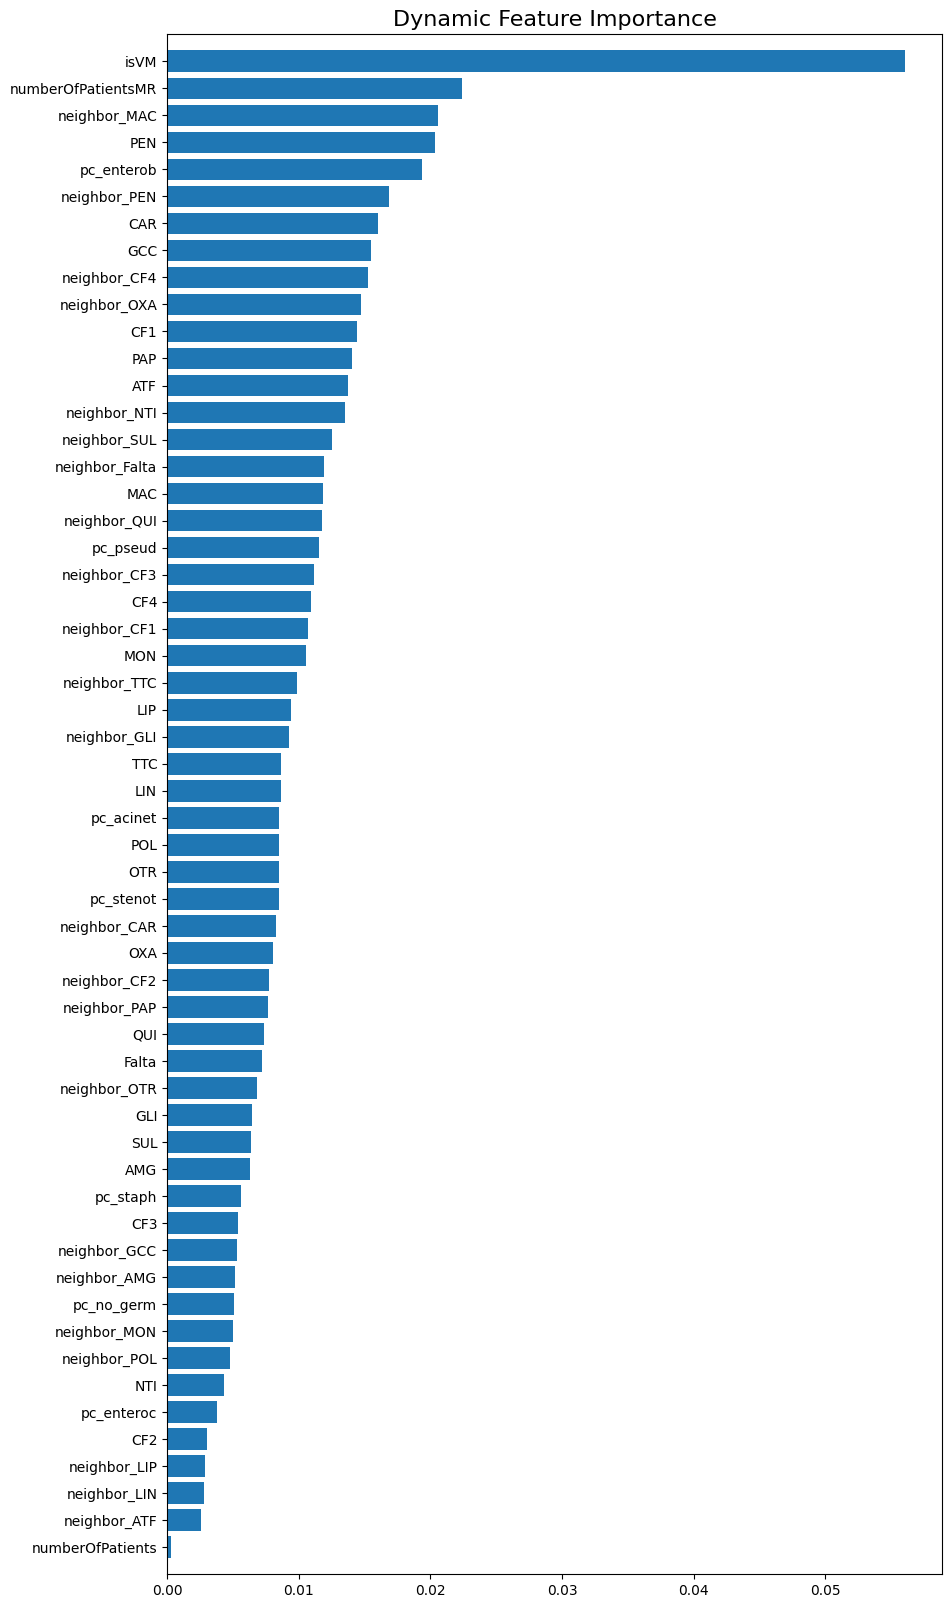

In [5]:
seed_value = 42
 
n = 4
for i in [0]:  
    results_perm_dyn = []
    for k in range(features_dyn.shape[0]):
        split_directory = f'./Results_LFLR/split_{i}'
        X_train = np.load(f"../splits_14_days/notbalanced/split_{i}/X_train_tensor_{n}.npy")
       
        y_train = pd.read_csv(f"../splits_14_days/notbalanced/split_{i}/y_train_{n}.csv", index_col=0)
        X_val = np.load(f"../splits_14_days/notbalanced/split_{i}/X_val_tensor_{n}.npy")
        X_val_static = pd.read_csv(f"../splits_14_days/notbalanced/split_{i}/X_val_static_{n}.csv", index_col=0)
        y_val = pd.read_csv(f"../splits_14_days/notbalanced/split_{i}/y_val_{n}.csv", index_col=0)
        X_test_dynamic = np.load(f"../splits_14_days/notbalanced/split_{i}/X_test_tensor.npy")
        X_test_static = pd.read_csv(f"../splits_14_days/notbalanced/split_{i}/X_test_static.csv", index_col=0)
        y_test = pd.read_csv(f"../splits_14_days/notbalanced/split_{i}/y_test.csv", index_col=0)

        save_col = X_val[:,:,k].copy()
        X_val = permutation_time_series(X_val, k, hyperparameters, seed=seed_value)

        model_stat = load_keras_model(os.path.join(f'../../EXPERIMENTS/0_WITHOUT_FS/Results_LFLR/Static/split_{i}/', "model.h5"))
        model_dyn = load_keras_model(os.path.join(f'../../EXPERIMENTS/0_WITHOUT_FS/Results_LFLR/Dynamic/split_{i}/', "model.h5"))
        model_LR = load_keras_model(os.path.join(f'../../EXPERIMENTS/0_WITHOUT_FS/Results_LFLR/LR/split_{i}/', "model.h5"))
        y_pred = load_predictions(os.path.join(f'../../EXPERIMENTS/0_WITHOUT_FS/Results_LFLR/LR/split_{i}/', "y_test_pred.pkl"))

        roc_baseline = sklearn.metrics.roc_auc_score(y_test.individualMRGerm.values, y_pred)
        # Compute ROC with feature K shuffled
        y_pred_dynamic = model_dyn.predict(x=[X_val], verbose=0) 
        y_pred_static = model_stat.predict(x=[X_val_static], verbose=0) 
        y_val_summary = y_val.reset_index()
        y_val_summary["y_pred_static"] = y_pred_static
        y_val_summary["y_pred_dynamic"] = y_pred_dynamic
        y_pred = model_LR.predict(x=(y_val_summary[["y_pred_static", "y_pred_dynamic"]]), verbose=0) 
        roc = sklearn.metrics.roc_auc_score(y_val.individualMRGerm.values, y_pred)

        results_perm_dyn.append(roc_baseline - roc)
        X_val[:,:,k] = save_col

    # Display GRU feature importance
    if i == 0:
        df = pd.DataFrame()
    df["roc_seed_" + str(i)] = results_perm_dyn
    df["features_dyn"] = features_dyn
    df = df.set_index("features_dyn")
        
plt.figure(figsize=(10,20))
plt.barh(np.arange(len(features_dyn)), df.mean(axis=1).sort_values().values)
plt.yticks(np.arange(len(features_dyn)), df.mean(axis=1).sort_values().index.values)
plt.title('Dynamic Feature Importance',size=16)
plt.ylim((-1,len(features_dyn)))
output_path = os.path.join(split_directory, "dynamic_feature_importance.pdf")
plt.savefig(output_path, format='pdf', bbox_inches='tight')
plt.show()


## PERMUTATION - STATIC FEATURES

In [6]:
features_static = ['Age', 'Gender', 'SAPSIIIScore', 'MonthOfAdmission', 'YearOfAdmission',
 'Origin', 'ReasonAdmission', 'PatientCategory']


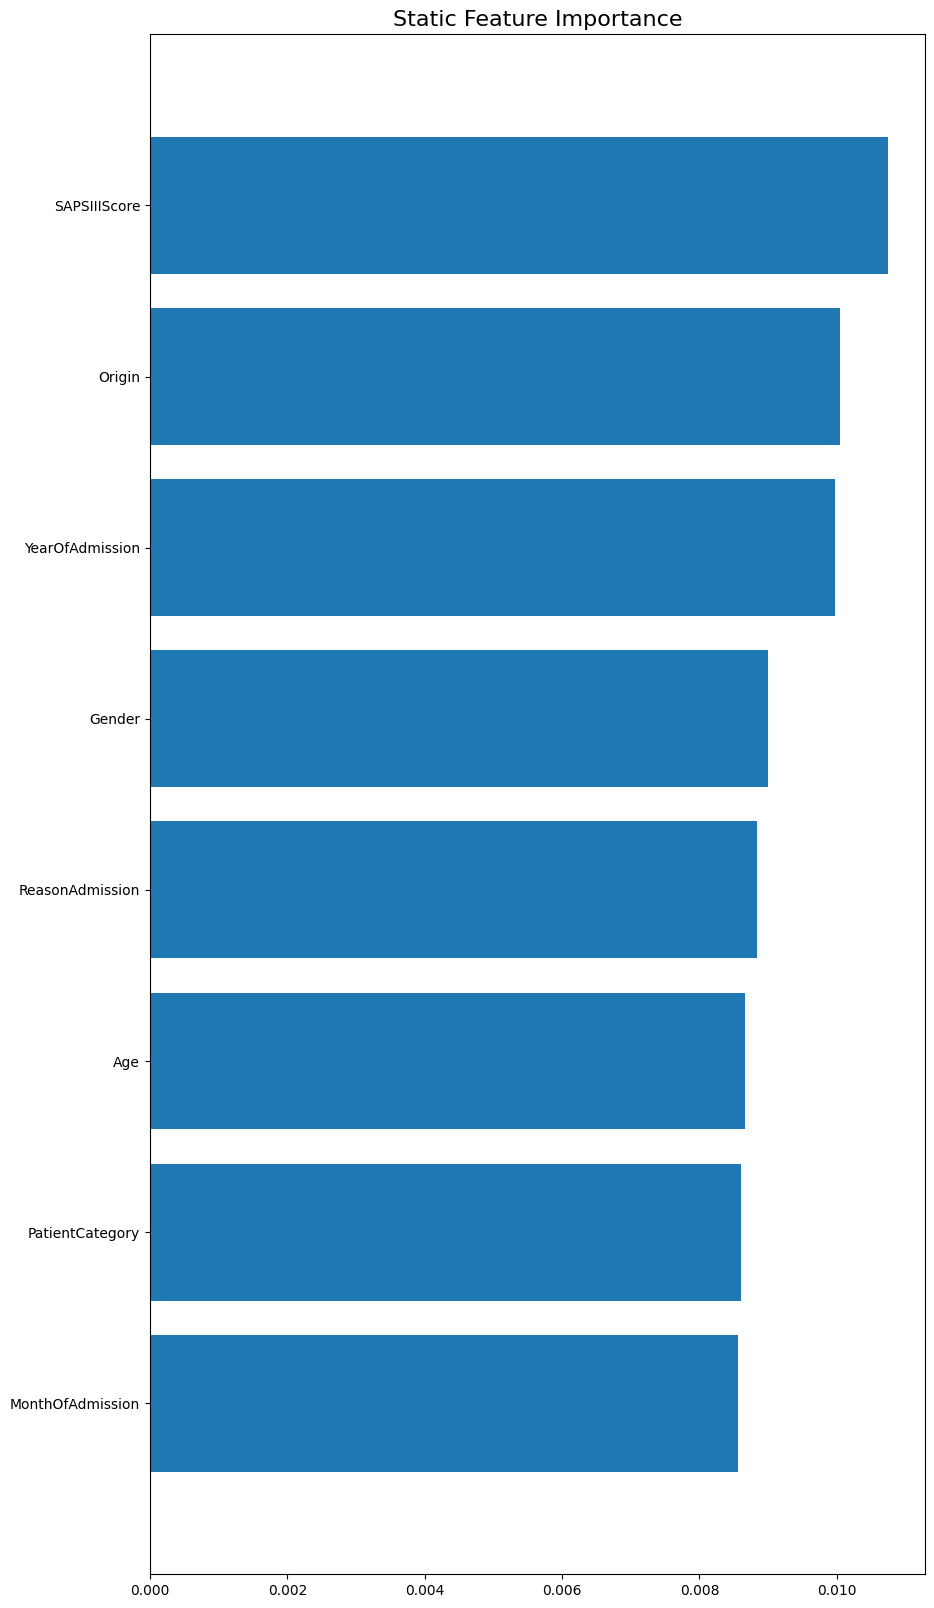

In [7]:
for i in [0]:
    split_directory = f'./Results_LFLR/split_{i}'
    results_perm_static = []
    for k in range(len(features_static)):
        X_train = np.load("../splits_14_days/notbalanced/split_" + str(i) +
                              "/X_train_tensor_" + str(n)+ ".npy")
       
        y_train = pd.read_csv("../splits_14_days/notbalanced/split_" + str(i) +
                              "/y_train_" + str(n)+ ".csv",
                             index_col=0)
        X_val = np.load("../splits_14_days/notbalanced/split_" + str(i) +
                            "/X_val_tensor_" + str(n)+ ".npy")
        X_val_static = pd.read_csv("../splits_14_days/notbalanced/split_" + str(i) +
                                 "/X_val_static_" + str(n)+ ".csv", index_col=0)
        y_val = pd.read_csv("../splits_14_days/notbalanced/split_" + str(i) +
                            "/y_val_" + str(n)+ ".csv",
                           index_col=0)
        X_test_dynamic = np.load("../splits_14_days/notbalanced/split_" + str(i) + "/X_test_tensor.npy")
        X_test_static = pd.read_csv("../splits_14_days/notbalanced/split_" + str(i) + "/X_test_static.csv",
                                   index_col=0)
        y_test = pd.read_csv("../splits_14_days/notbalanced/split_" + str(i) + "/y_test.csv",
                            index_col=0)
        
        X_val_static = X_val_static.values
        # Shuffle feature K
        save_col = X_val_static[:,k].copy()
        
        np.random.seed(seed_value)  # Set seed for reproducibility
        np.random.shuffle(X_val_static[:,k])

        model_stat = load_keras_model(os.path.join(f'../../EXPERIMENTS/0_WITHOUT_FS/Results_LFLR/Static/split_{i}/', f"model.h5"))
        model_dyn = load_keras_model(os.path.join(f'../../EXPERIMENTS/0_WITHOUT_FS/Results_LFLR/Dynamic/split_{i}/', f"model.h5"))
        model_LR = load_keras_model(os.path.join(f'../../EXPERIMENTS/0_WITHOUT_FS/Results_LFLR/LR/split_{i}/', f"model.h5"))
        y_pred = load_predictions(os.path.join(f'../../EXPERIMENTS/0_WITHOUT_FS/Results_LFLR/LR/split_{i}/', f"y_test_pred.pkl"))

        roc_baseline = sklearn.metrics.roc_auc_score(y_test.individualMRGerm.values, y_pred)
        # Compute ROC with feature K shuffled
        y_pred_dynamic =  model_dyn.predict(x=[X_val], verbose=0) 
        y_pred_static =  model_stat.predict(x=[X_val_static], verbose=0) 
        y_val_summary = y_val.reset_index()
        y_val_summary["y_pred_static"] = y_pred_static
        y_val_summary["y_pred_dynamic"] = y_pred_dynamic
        y_pred = model_LR.predict(x=(y_val_summary[["y_pred_static", "y_pred_dynamic"]]), verbose=0) 
        roc = sklearn.metrics.roc_auc_score(y_val.individualMRGerm.values, y_pred)

        results_perm_static.append(roc_baseline - roc)
        X_val_static[:, k] = save_col
    
    # Display GRU feature importance
    print()
    if i == 0:
        df_static = pd.DataFrame()
    df_static["roc_seed_" + str(i)] = results_perm_static
    df_static["features_static"] = features_static
    df_static = df_static.set_index("features_static")

plt.figure(figsize=(10,20))
plt.barh(np.arange(len(features_static)), df_static.mean(axis=1).sort_values().values)
plt.yticks(np.arange(len(features_static)), df_static.mean(axis=1).sort_values().index.values)
plt.title('Static Feature Importance',size=16)
plt.ylim((-1,len(features_static)))
output_path = os.path.join(split_directory, "static_feature_importance.pdf")
plt.savefig(output_path, format='pdf', bbox_inches='tight')
plt.show()
print()

In [8]:
df["mean_importance"] = df.mean(axis=1)

top_features_dyn = df["mean_importance"].nlargest(5).index.tolist()
print("5 best features:", top_features_dyn)

dynamic = pd.DataFrame(top_features_dyn, columns=['Selected Feature'])


df_static["mean_importance"] = df_static.mean(axis=1)
top_features_static = df_static["mean_importance"].nlargest(3).index.tolist()
print("3 best features:", top_features_static)

static = pd.DataFrame(top_features_static, columns=['Selected Feature'])

combined = pd.concat([
    dynamic['Selected Feature'],
    static['Selected Feature']], ignore_index=True)

combined.to_csv('../0_Results_FS_PFI/LFLR_selected_features.csv', index=False)

5 best features: ['isVM', 'numberOfPatientsMR', 'neighbor_MAC', 'PEN', 'pc_enterob']
3 best features: ['SAPSIIIScore', 'Origin', 'YearOfAdmission']
